# Correlations in the data frames.

Which data columns correlate with each other, and why?

## Import the libraries.

This is my standard import.

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json
import random

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor, ClassifierChain
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress
from scipy.cluster.hierarchy import linkage, fcluster

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'


from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib


# Read the data

In [2]:
sequence_type = "MGI"
datadir = '..'
#sslevel = 'level2_norm_ss.tsv.gz'
sslevel = 'subsystems_norm_ss.tsv.gz'
ss_df = cf_analysis_lib.read_subsystems(os.path.join(datadir, sequence_type, "FunctionalAnalysis", "subsystems", sslevel), sequence_type)
ss_df = ss_df.T
print(f"The subsystems df has shape: {ss_df.shape}")

taxa = "family"
genus_otu = cf_analysis_lib.read_taxonomy(datadir, sequence_type, taxa)
genus_otu = genus_otu.T
print(f"The taxonomy df has shape: {genus_otu.shape}")
metadata = cf_analysis_lib.read_metadata(datadir, sequence_type, categorise=True)
print(f"The metadata df has shape: {metadata.shape}")
df = ss_df.merge(genus_otu, left_index=True, right_index=True, how='inner')
print(df.shape)
df.head(5)

The subsystems df has shape: (127, 769)
The taxonomy df has shape: (127, 743)
The metadata df has shape: (127, 166)
(127, 1512)


,"2,3-diacetamido-2,3-dideoxy-d-mannuronic acid",2-O-alpha-mannosyl-D-glycerate utilization,2-aminophenol Metabolism,2-ketoacid oxidoreductases disambiguation,2-oxoglutarate dehydrogenase,2-phosphoglycolate salvage,3-amino-5-hydroxybenzoic Acid Synthesis,4-hydroxybenzoyl-CoA reductase,5-methylaminomethyl-2-thiouridine,A Hypothetical Protein Related to Proline Metabolism,...,Pelagicoccaceae,Puniceicoccaceae,Chthoniobacteraceae,Terrimicrobiaceae,Limisphaeraceae,Akkermansiaceae,Rubritaleaceae,Verrucomicrobia subdivision 6,Verrucomicrobiaceae,Eremiobacteraceae
1068841_20180306_S,10.085904,2784.895948,516.160945,231.778018,122.573392,342.327431,783.041862,0.0,4136.703664,827.439614,...,0.000000,0.808564,0.0,0.0,0.0,22.370261,0.808564,0.0,3.234255,0.0
1447437_20171212_S,59.260325,1065.438272,543.947408,554.136026,428.171446,301.915763,679.310468,0.0,3913.676651,732.956657,...,1.271183,0.635592,0.0,0.0,0.0,36.864321,0.000000,0.0,3.177959,0.0
1128691_20171206_S,0.000000,426.619709,912.767750,49.606943,213.640568,277.798880,423.312580,0.0,2093.412992,236.459761,...,0.000000,10.749798,0.0,0.0,0.0,14.333065,0.000000,0.0,10.749798,0.0
1128691_20171218_S,0.000000,659.087578,864.137047,139.140711,235.318676,355.174973,538.254855,0.0,2050.494687,341.749115,...,0.000000,0.000000,0.0,0.0,0.0,11.285217,0.000000,0.0,5.642608,0.0
1128691_20180116_S,14.478968,159.268644,593.637673,48.263225,358.354449,202.705547,348.701804,0.0,1570.967988,205.118708,...,0.000000,15.607929,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


## Calculate the correlation matrix and filter for correlations > 0.7

In [34]:
corr = df.corr()
threshold = 0.3
corr_thresholded = corr.where(corr > threshold, 0)
corr_thresholded.head()
#corr.head()

,"2,3-diacetamido-2,3-dideoxy-d-mannuronic acid",2-O-alpha-mannosyl-D-glycerate utilization,2-aminophenol Metabolism,2-ketoacid oxidoreductases disambiguation,2-oxoglutarate dehydrogenase,2-phosphoglycolate salvage,3-amino-5-hydroxybenzoic Acid Synthesis,4-hydroxybenzoyl-CoA reductase,5-methylaminomethyl-2-thiouridine,A Hypothetical Protein Related to Proline Metabolism,...,Pelagicoccaceae,Puniceicoccaceae,Chthoniobacteraceae,Terrimicrobiaceae,Limisphaeraceae,Akkermansiaceae,Rubritaleaceae,Verrucomicrobia subdivision 6,Verrucomicrobiaceae,Eremiobacteraceae
"2,3-diacetamido-2,3-dideoxy-d-mannuronic acid",1.000000,0.0,0.492657,0.533865,0.0,0.362250,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2-O-alpha-mannosyl-D-glycerate utilization,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.631176,0.316822,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2-aminophenol Metabolism,0.492657,0.0,1.000000,0.000000,0.0,0.581969,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2-ketoacid oxidoreductases disambiguation,0.533865,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.362718,0.0,0.0,0.0,0.0
2-oxoglutarate dehydrogenase,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


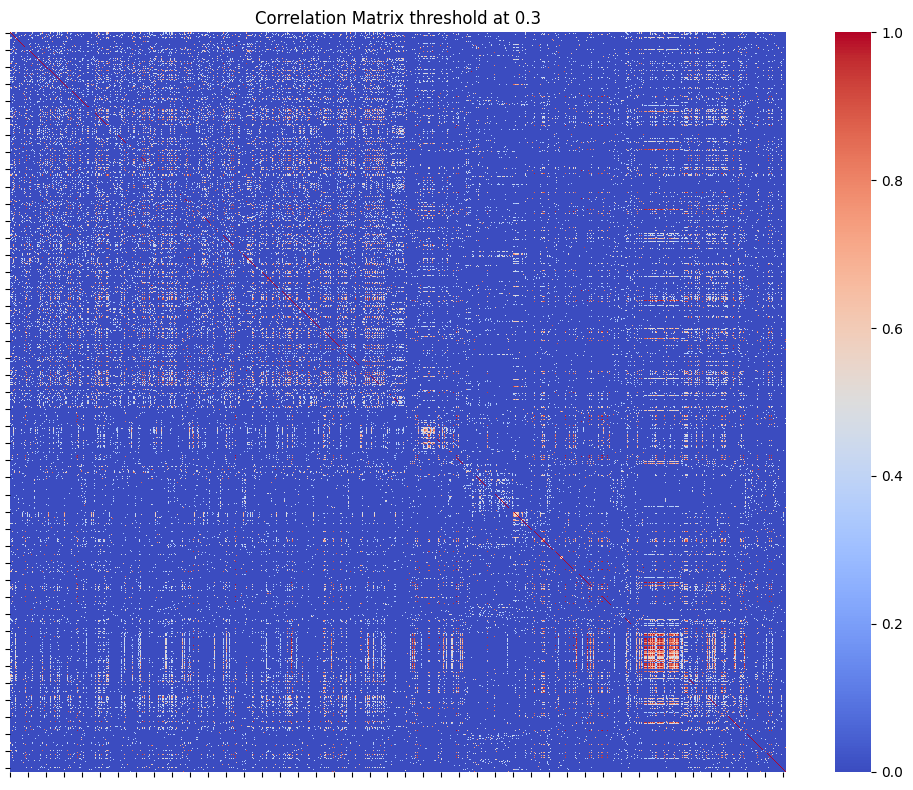

In [35]:
plt.figure(figsize=(10, 8))
g = sns.heatmap(corr_thresholded, cmap='coolwarm')
g.set_yticklabels([])
g.set_xticklabels([])
plt.title(f'Correlation Matrix threshold at {threshold}')
plt.tight_layout()
plt.show()

In [36]:
# Calculate linkage on the rows (i.e., the features)
Z = linkage(corr_thresholded, method='ward', metric='euclidean')

k = 150  # more clusters, smaller groups!
clusters = fcluster(Z, k, criterion='maxclust')  # Each feature gets a cluster ID [1..k]

# create a df with the cluster assignments
cluster_assignments = pd.DataFrame({
    "Feature": corr_thresholded.index,  # the feature names
    "Cluster": clusters
})
cluster_assignments.sort_values("Cluster", inplace=True)

In [37]:
interesting_cluster = None
interesting_cluster_count = 0
grouped = cluster_assignments.groupby("Cluster")
for cluster_id, group in grouped:
    if group['Feature'].str.contains('Pseudomonas').any():
        if group['Feature'].str.contains('Pseudomonas').sum() > interesting_cluster_count:
            interesting_cluster_count = group['Feature'].str.contains('Pseudomonas').sum()
            interesting_cluster = cluster_id
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---")
        print(group["Feature"].tolist())
        print()

--- Cluster 1 : Length 38 ---
['L-2-amino-4-methoxy-trans-3-butenoic acid synthesis', 'Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas', 'Extracellular matrix proteins (PSL) involved in mannose-rich biofilm formation in Pseudomonas', 'Colwelliaceae', 'Adenylylsulfate reductase', 'Outer membrane porins in Pseudomonas and Acinetobacter', 'Cholera toxin', 'Potential DNA repair cluster', 'Malonate decarboxylase', 'Two partner secretion pathway (TPS)', 'Carbon storage regulator', 'CMP-pseudaminic acid synthesis', 'Type III secretion system', 'Type III secretion systems', 'Mycobacterial FadD proteins (fatty acid CoA- and AMP- ligases)', 'Mycobacterial FadE proteins Acyl-CoA dehydrogenase', 'Heme and heme d1 biosynthesis from siroheme', 'Mycobacterial gene cluster associated with resistance against FAS-II antibiotics', 'Biogenesis of cbb3-type cytochrome c oxidases', 'Beta-lactamases Ambler class D', 'Phenazine biosynthesis', 'Periplasmic nitrate 

In [38]:
singletons = 0
for cluster_id, group in grouped:
    if group['Feature'].shape[0] == 1:
        singletons+=1
print(f"There are {singletons} single clusters")

There are 0 single clusters


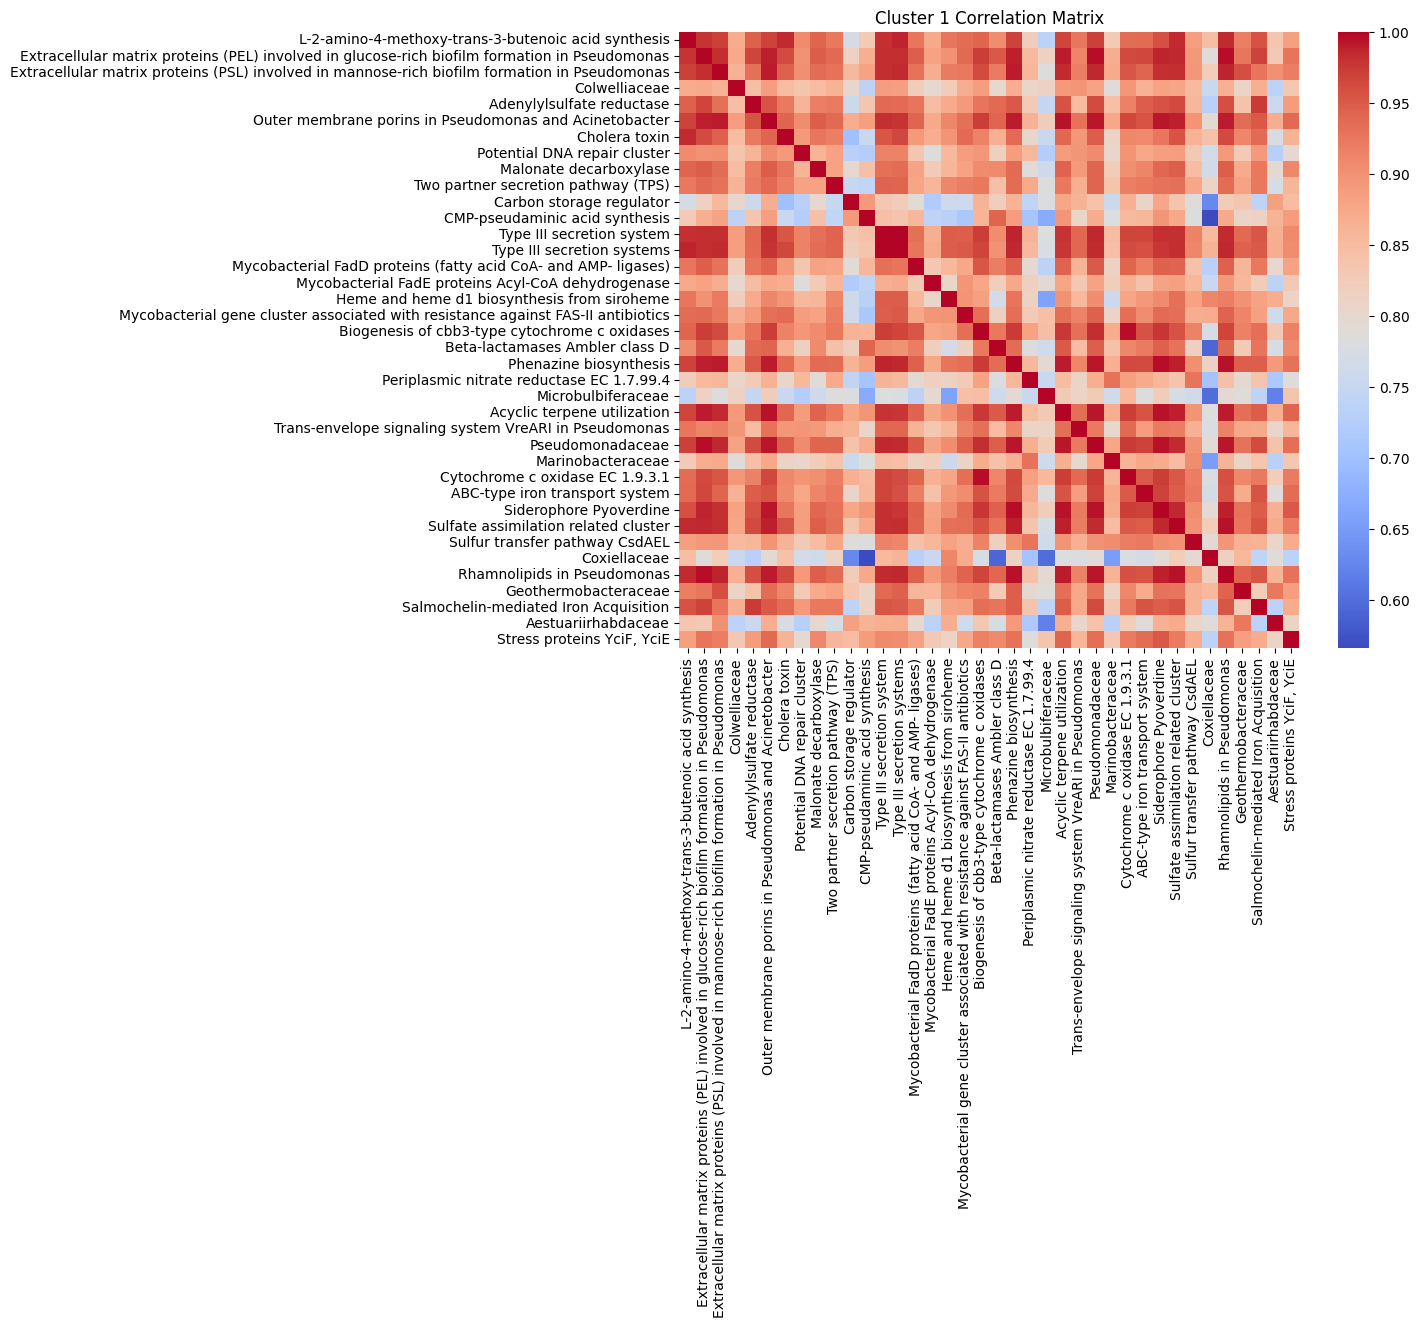

In [39]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
df_clust_corr = df_clust.corr()
plt.figure(figsize=(10, 8))
g = sns.heatmap(df_clust_corr, annot=False, cmap='coolwarm')
plt.title(f'Cluster {interesting_cluster} Correlation Matrix')
plt.show()